# Config

In [1]:
from __future__ import print_function
from pyspark import SparkContext , SparkConf
import sys
from operator import add
from csv import reader
from pyspark.sql import SQLContext, SparkSession
import numpy as np

In [2]:
from pyspark.sql.functions import col, lit, when, signum, avg, count, sum, round, abs

In [3]:
from matplotlib import pyplot as plt

In [4]:
from matplotlib.patches import Arc
import seaborn as sns

In [5]:
from scipy.special import softmax
import pandas as pd

In [6]:
cf = SparkConf()
cf.set("spark.submit.deployMode","client")

sc = SparkContext.getOrCreate(cf)

spark = SparkSession.builder.appName("Analysis_RDS").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/11 21:43:03 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/12/11 21:43:03 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/12/11 21:43:03 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/11 21:43:03 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


# Data view

In [7]:
filepath = 'Project/Data/Format_data/competitions.parquet'
df_comp_data = spark.read.parquet(filepath)
df_comp_data.printSchema()

root
 |-- competition_gender: string (nullable = true)
 |-- competition_id: long (nullable = true)
 |-- competition_international: boolean (nullable = true)
 |-- competition_name: string (nullable = true)
 |-- competition_youth: boolean (nullable = true)
 |-- country_name: string (nullable = true)
 |-- match_available: string (nullable = true)
 |-- match_available_360: string (nullable = true)
 |-- match_updated: string (nullable = true)
 |-- match_updated_360: string (nullable = true)
 |-- season_id: long (nullable = true)
 |-- season_name: string (nullable = true)



In [8]:
#Data cohort for consideration
leagues = ['La Liga','Premier League','Serie A','Ligue 1','1. Bundesliga']
season = '2015/16'
season_id = 27
gender = 'male'

In [9]:
filepath = 'Project/Data/Format_data/matches.parquet'
df_matches_data = spark.read.parquet(filepath)
df_matches_data.printSchema()

root
 |-- away_score: long (nullable = true)
 |-- away_team_away_team_gender: string (nullable = true)
 |-- away_team_away_team_group: string (nullable = true)
 |-- away_team_away_team_id: long (nullable = true)
 |-- away_team_away_team_name: string (nullable = true)
 |-- away_team_managers_country_id: long (nullable = true)
 |-- away_team_managers_country_name: string (nullable = true)
 |-- away_team_managers_name: string (nullable = true)
 |-- away_team_managers_dob: string (nullable = true)
 |-- away_team_managers_id: long (nullable = true)
 |-- away_team_managers_nickname: string (nullable = true)
 |-- competition_competition_id: long (nullable = true)
 |-- competition_competition_name: string (nullable = true)
 |-- competition_country_name: string (nullable = true)
 |-- competition_stage_id: long (nullable = true)
 |-- competition_stage_name: string (nullable = true)
 |-- home_score: long (nullable = true)
 |-- home_team_home_team_gender: string (nullable = true)
 |-- home_team_ho

In [10]:
df_comp_focus = df_comp_data.filter((col('competition_name').isin(leagues)) &
                   (col('season_id')==season_id))

In [11]:
## Getting all matches based on the competition in focus

condition = [(df_matches_data.competition_competition_id == df_comp_focus.competition_id) &
             (df_matches_data.season_season_id == df_comp_focus.season_id)]
df_match_focus = df_matches_data.join(df_comp_focus, on = condition,how= 'inner')

In [12]:
df_shot_data = spark.read.parquet('/user/dc5415_nyu_edu/Project/Data/Format_data/event_shot.parquet')
df_shot_data.printSchema()

root
 |-- shot_aerial_won: boolean (nullable = true)
 |-- shot_follows_dribble: boolean (nullable = true)
 |-- shot_kick_off: boolean (nullable = true)
 |-- shot_one_on_one: boolean (nullable = true)
 |-- shot_redirect: boolean (nullable = true)
 |-- shot_saved_off_target: boolean (nullable = true)
 |-- shot_saved_to_post: boolean (nullable = true)
 |-- shot_key_pass_id: string (nullable = true)
 |-- shot_end_location: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- shot_first_time: boolean (nullable = true)
 |-- shot_open_goal: boolean (nullable = true)
 |-- shot_statsbomb_xg: double (nullable = true)
 |-- shot_deflected: boolean (nullable = true)
 |-- shot_technique_id: long (nullable = true)
 |-- shot_technique_name: string (nullable = true)
 |-- shot_body_part_id: long (nullable = true)
 |-- shot_body_part_name: string (nullable = true)
 |-- shot_type_id: long (nullable = true)
 |-- shot_type_name: string (nullable = true)
 |-- shot_outcome_id: long (nu

In [13]:
df_shot_focus = df_shot_data.join(df_match_focus, on = ['match_id'], how = 'inner')
df_shot_focus.count()

45720

In [14]:
pd_shot_focus = df_shot_focus.select('competition_competition_id','competition_competition_name',
                                    'team_id','team_name','location','shot_outcome_name','shot_type_name').toPandas()

In [15]:
pd_shot_focus['location_x'] = pd_shot_focus['location'].apply(lambda x: x[0])
pd_shot_focus['location_y'] = pd_shot_focus['location'].apply(lambda x: x[1])

pd_shot_focus[['location_x','location_y']].head()

,location_x,location_y
0,107.3,37.9
1,113.4,39.8
2,80.2,44.3
3,103.2,35.7
4,116.3,45.8


In [16]:
pd_shot_focus[['location_x','location_y']].describe()

,location_x,location_y
count,45720.000000,45720.000000
mean,103.336853,39.790626
std,8.756693,9.961271
min,35.400000,0.300000
25%,96.900000,32.400000
50%,104.700000,39.900000
75%,110.300000,47.100000
max,120.400000,80.000000


# Plot - Competition wise

In [17]:
comp_names = list(pd_shot_focus['competition_competition_name'].unique())
comp_names

['La Liga', 'Premier League', 'Serie A', 'Ligue 1', '1. Bundesliga']

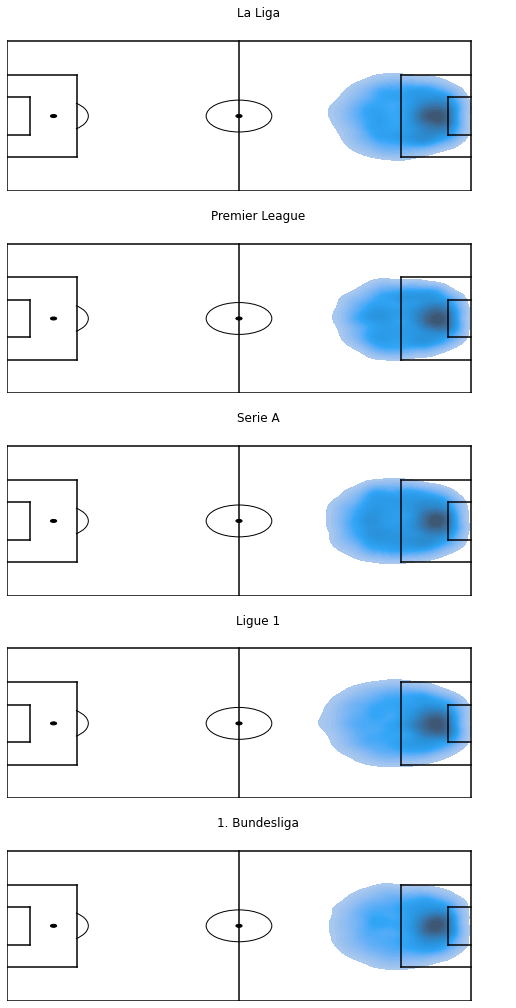

In [19]:
fig=plt.figure(figsize = (9,18))

for idx,_ in enumerate(comp_names):
    ax=fig.add_subplot(5,1,idx+1)

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,80], color="black")
    plt.plot([0,120],[80,80], color="black")
    plt.plot([120,120],[80,0], color="black")
    plt.plot([120,0],[0,0], color="black")
    plt.plot([60,60],[0,80], color="black")

    #Left Penalty Area
    plt.plot([18,18],[62,18],color="black")
    plt.plot([0,18],[62,62],color="black")
    plt.plot([0,18],[18,18],color="black")

    #Right Penalty Area
    plt.plot([102,102],[18,62],color="black")
    plt.plot([102,120],[62,62],color="black")
    plt.plot([102,120],[18,18],color="black")


    #Left 6-yard Box
    plt.plot([0,6],[30,30],color="black")
    plt.plot([6,6],[50,30],color="black")
    plt.plot([0,6],[50,50],color="black")

    #Right 6-yard Box
    plt.plot([114,114],[50,30],color="black")
    plt.plot([114,120],[30,30],color="black")
    plt.plot([114,120],[50,50],color="black")

    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.5,color="black",fill=False)
    centreSpot = plt.Circle((60,40),0.8,color="black")
    leftPenSpot = plt.Circle((12,40),0.8,color="black")
    rightPenSpot = plt.Circle((108,40),0.8,color="black")

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)


    leftArc = Arc((12,40),height=18,width=18,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((108,40),height=18,width=18,angle=0,theta1=130,theta2=230,color="black")

    ax.add_patch(leftArc)
    ax.add_patch(rightArc)
    plt.axis('off')
    plt.title(_)

    #Tidy Axes
    plt.axis('off')
    plt.title(_) 
    shot_focus = pd_shot_focus[(pd_shot_focus['competition_competition_name']==_) &
                               (pd_shot_focus['shot_type_name']!='Penalty')]
    sns.kdeplot(data = shot_focus, x ="location_x",y = "location_y", shade="True", n_levels=40,cbar_ax = ax)
#     sns.kdeplot(data = shot_focus[shot_focus['shot_outcome_name']=='Goal'], x ="location_x",y = "location_y", shade="True", n_levels=40,cbar_ax = ax)
    plt.ylim(0, 80)
    plt.xlim(0, 120)


    #Display Pitch
    ax.plot()

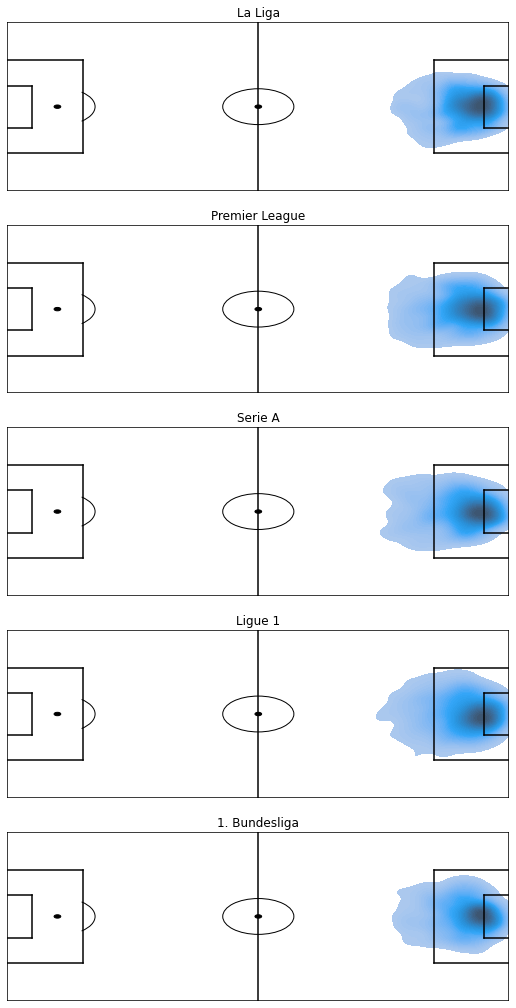

In [23]:
fig=plt.figure(figsize = (9,18))

for idx,_ in enumerate(comp_names):
    ax=fig.add_subplot(5,1,idx+1)

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,80], color="black")
    plt.plot([0,120],[80,80], color="black")
    plt.plot([120,120],[80,0], color="black")
    plt.plot([120,0],[0,0], color="black")
    plt.plot([60,60],[0,80], color="black")

    #Left Penalty Area
    plt.plot([18,18],[62,18],color="black")
    plt.plot([0,18],[62,62],color="black")
    plt.plot([0,18],[18,18],color="black")

    #Right Penalty Area
    plt.plot([102,102],[18,62],color="black")
    plt.plot([102,120],[62,62],color="black")
    plt.plot([102,120],[18,18],color="black")


    #Left 6-yard Box
    plt.plot([0,6],[30,30],color="black")
    plt.plot([6,6],[50,30],color="black")
    plt.plot([0,6],[50,50],color="black")

    #Right 6-yard Box
    plt.plot([114,114],[50,30],color="black")
    plt.plot([114,120],[30,30],color="black")
    plt.plot([114,120],[50,50],color="black")

    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.5,color="black",fill=False)
    centreSpot = plt.Circle((60,40),0.8,color="black")
    leftPenSpot = plt.Circle((12,40),0.8,color="black")
    rightPenSpot = plt.Circle((108,40),0.8,color="black")

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)


    leftArc = Arc((12,40),height=18,width=18,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((108,40),height=18,width=18,angle=0,theta1=130,theta2=230,color="black")

    ax.add_patch(leftArc)
    ax.add_patch(rightArc)

    #Tidy Axes
    plt.axis('off')
    plt.title(_) 
    shot_focus = pd_shot_focus[(pd_shot_focus['competition_competition_name']==_) &
                               (pd_shot_focus['shot_type_name']!='Penalty')]
#     sns.kdeplot(data = shot_focus, x ="location_x",y = "location_y", shade="True", n_levels=40,cbar_ax = ax)
    sns.kdeplot(data = shot_focus[shot_focus['shot_outcome_name']=='Goal'], x ="location_x",y = "location_y", shade="True", n_levels=40,cbar_ax = ax)
    plt.ylim(0, 80)
    plt.xlim(0, 120)


    #Display Pitch
    ax.plot()

# Plot - Team wise [LaLiga]

In [24]:
top5teams = ['Barcelona','Real Madrid','Atlético Madrid','Villarreal']
bottom5teams = ['Sporting Gijón','Rayo Vallecano','Getafe','Levante UD']

In [28]:
pd_team_shot_focus=pd_shot_focus[pd_shot_focus.competition_competition_name == 'La Liga']

## Top-5

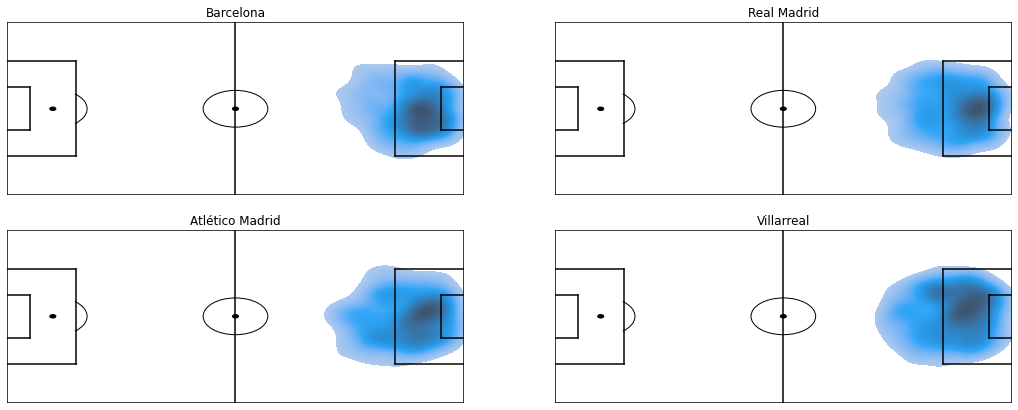

In [44]:
fig=plt.figure(figsize = (18,7))

for idx,_ in enumerate(top5teams):
    ax=fig.add_subplot(2,2,idx+1)

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,80], color="black")
    plt.plot([0,120],[80,80], color="black")
    plt.plot([120,120],[80,0], color="black")
    plt.plot([120,0],[0,0], color="black")
    plt.plot([60,60],[0,80], color="black")

    #Left Penalty Area
    plt.plot([18,18],[62,18],color="black")
    plt.plot([0,18],[62,62],color="black")
    plt.plot([0,18],[18,18],color="black")

    #Right Penalty Area
    plt.plot([102,102],[18,62],color="black")
    plt.plot([102,120],[62,62],color="black")
    plt.plot([102,120],[18,18],color="black")


    #Left 6-yard Box
    plt.plot([0,6],[30,30],color="black")
    plt.plot([6,6],[50,30],color="black")
    plt.plot([0,6],[50,50],color="black")

    #Right 6-yard Box
    plt.plot([114,114],[50,30],color="black")
    plt.plot([114,120],[30,30],color="black")
    plt.plot([114,120],[50,50],color="black")

    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.5,color="black",fill=False)
    centreSpot = plt.Circle((60,40),0.8,color="black")
    leftPenSpot = plt.Circle((12,40),0.8,color="black")
    rightPenSpot = plt.Circle((108,40),0.8,color="black")

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)


    leftArc = Arc((12,40),height=18,width=18,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((108,40),height=18,width=18,angle=0,theta1=130,theta2=230,color="black")

    ax.add_patch(leftArc)
    ax.add_patch(rightArc)

    #Tidy Axes
    plt.axis('off')
    plt.title(_) 
    shot_focus = pd_team_shot_focus[(pd_team_shot_focus['team_name']==_)  &
                               (pd_team_shot_focus['shot_type_name']=='Open Play')]
    sns.kdeplot(data = shot_focus, x ="location_x",y = "location_y", shade="True", n_levels=90,cbar_ax = ax)
#     sns.kdeplot(data = shot_focus[shot_focus['shot_outcome_name']=='Goal'], x ="location_x",y = "location_y", shade="True", n_levels=40,cbar_ax = ax)
    plt.ylim(0, 80)
    plt.xlim(0, 120)


    #Display Pitch
    ax.plot()

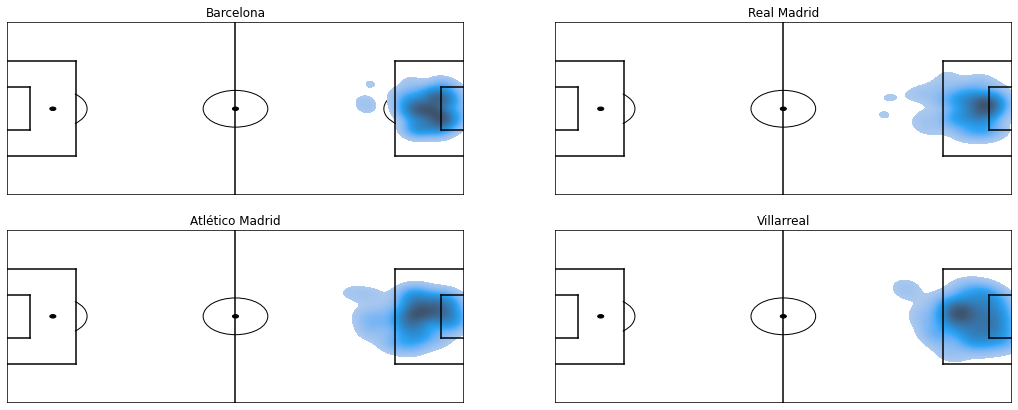

In [45]:
fig=plt.figure(figsize = (18,7))

for idx,_ in enumerate(top5teams):
    ax=fig.add_subplot(2,2,idx+1)

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,80], color="black")
    plt.plot([0,120],[80,80], color="black")
    plt.plot([120,120],[80,0], color="black")
    plt.plot([120,0],[0,0], color="black")
    plt.plot([60,60],[0,80], color="black")

    #Left Penalty Area
    plt.plot([18,18],[62,18],color="black")
    plt.plot([0,18],[62,62],color="black")
    plt.plot([0,18],[18,18],color="black")

    #Right Penalty Area
    plt.plot([102,102],[18,62],color="black")
    plt.plot([102,120],[62,62],color="black")
    plt.plot([102,120],[18,18],color="black")


    #Left 6-yard Box
    plt.plot([0,6],[30,30],color="black")
    plt.plot([6,6],[50,30],color="black")
    plt.plot([0,6],[50,50],color="black")

    #Right 6-yard Box
    plt.plot([114,114],[50,30],color="black")
    plt.plot([114,120],[30,30],color="black")
    plt.plot([114,120],[50,50],color="black")

    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.5,color="black",fill=False)
    centreSpot = plt.Circle((60,40),0.8,color="black")
    leftPenSpot = plt.Circle((12,40),0.8,color="black")
    rightPenSpot = plt.Circle((108,40),0.8,color="black")

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)


    leftArc = Arc((12,40),height=18,width=18,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((108,40),height=18,width=18,angle=0,theta1=130,theta2=230,color="black")

    ax.add_patch(leftArc)
    ax.add_patch(rightArc)

    #Tidy Axes
    plt.axis('off')
    plt.title(_) 
    shot_focus = pd_team_shot_focus[(pd_team_shot_focus['team_name']==_)  &
                               (pd_team_shot_focus['shot_type_name']=='Open Play')]
#     sns.kdeplot(data = shot_focus, x ="location_x",y = "location_y", shade="True", n_levels=90,cbar_ax = ax)
    sns.kdeplot(data = shot_focus[shot_focus['shot_outcome_name']=='Goal'], x ="location_x",y = "location_y", shade="True", n_levels=90,cbar_ax = ax)
    plt.ylim(0, 80)
    plt.xlim(0, 120)


    #Display Pitch
    ax.plot()

## Bottom-5

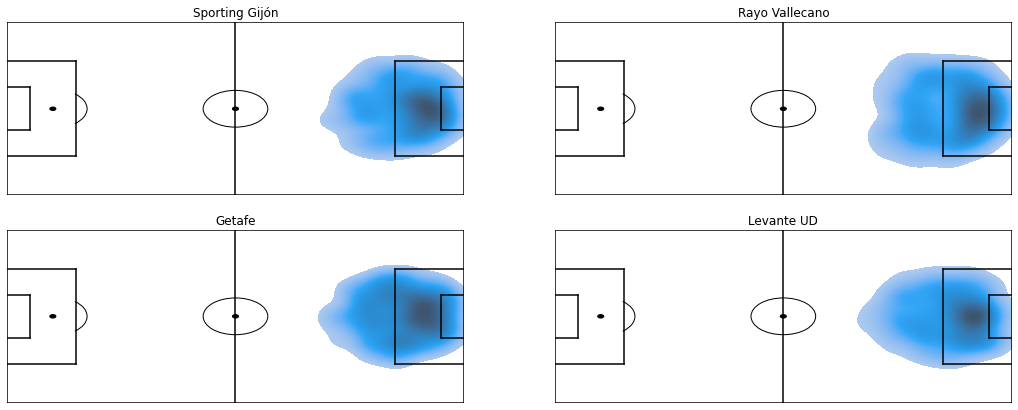

In [46]:
fig=plt.figure(figsize = (18,7))

for idx,_ in enumerate(bottom5teams):
    ax=fig.add_subplot(2,2,idx+1)

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,80], color="black")
    plt.plot([0,120],[80,80], color="black")
    plt.plot([120,120],[80,0], color="black")
    plt.plot([120,0],[0,0], color="black")
    plt.plot([60,60],[0,80], color="black")

    #Left Penalty Area
    plt.plot([18,18],[62,18],color="black")
    plt.plot([0,18],[62,62],color="black")
    plt.plot([0,18],[18,18],color="black")

    #Right Penalty Area
    plt.plot([102,102],[18,62],color="black")
    plt.plot([102,120],[62,62],color="black")
    plt.plot([102,120],[18,18],color="black")


    #Left 6-yard Box
    plt.plot([0,6],[30,30],color="black")
    plt.plot([6,6],[50,30],color="black")
    plt.plot([0,6],[50,50],color="black")

    #Right 6-yard Box
    plt.plot([114,114],[50,30],color="black")
    plt.plot([114,120],[30,30],color="black")
    plt.plot([114,120],[50,50],color="black")

    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.5,color="black",fill=False)
    centreSpot = plt.Circle((60,40),0.8,color="black")
    leftPenSpot = plt.Circle((12,40),0.8,color="black")
    rightPenSpot = plt.Circle((108,40),0.8,color="black")

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)


    leftArc = Arc((12,40),height=18,width=18,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((108,40),height=18,width=18,angle=0,theta1=130,theta2=230,color="black")

    ax.add_patch(leftArc)
    ax.add_patch(rightArc)

    #Tidy Axes
    plt.axis('off')
    plt.title(_) 
    shot_focus = pd_team_shot_focus[(pd_team_shot_focus['team_name']==_)  &
                               (pd_team_shot_focus['shot_type_name']=='Open Play')]
    sns.kdeplot(data = shot_focus, x ="location_x",y = "location_y", shade="True", n_levels=90,cbar_ax = ax)
#     sns.kdeplot(data = shot_focus[shot_focus['shot_outcome_name']=='Goal'], x ="location_x",y = "location_y", shade="True", n_levels=40,cbar_ax = ax)
    plt.ylim(0, 80)
    plt.xlim(0, 120)


    #Display Pitch
    ax.plot()

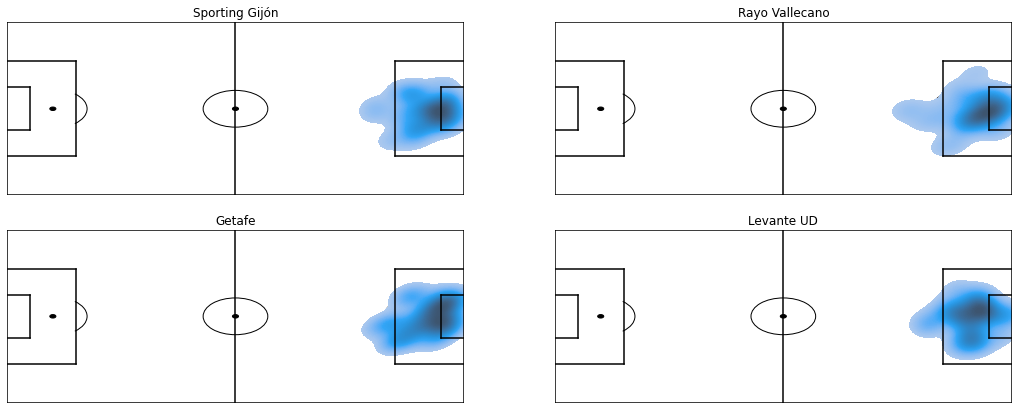

In [47]:
fig=plt.figure(figsize = (18,7))

for idx,_ in enumerate(bottom5teams):
    ax=fig.add_subplot(2,2,idx+1)

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,80], color="black")
    plt.plot([0,120],[80,80], color="black")
    plt.plot([120,120],[80,0], color="black")
    plt.plot([120,0],[0,0], color="black")
    plt.plot([60,60],[0,80], color="black")

    #Left Penalty Area
    plt.plot([18,18],[62,18],color="black")
    plt.plot([0,18],[62,62],color="black")
    plt.plot([0,18],[18,18],color="black")

    #Right Penalty Area
    plt.plot([102,102],[18,62],color="black")
    plt.plot([102,120],[62,62],color="black")
    plt.plot([102,120],[18,18],color="black")


    #Left 6-yard Box
    plt.plot([0,6],[30,30],color="black")
    plt.plot([6,6],[50,30],color="black")
    plt.plot([0,6],[50,50],color="black")

    #Right 6-yard Box
    plt.plot([114,114],[50,30],color="black")
    plt.plot([114,120],[30,30],color="black")
    plt.plot([114,120],[50,50],color="black")

    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.5,color="black",fill=False)
    centreSpot = plt.Circle((60,40),0.8,color="black")
    leftPenSpot = plt.Circle((12,40),0.8,color="black")
    rightPenSpot = plt.Circle((108,40),0.8,color="black")

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)


    leftArc = Arc((12,40),height=18,width=18,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((108,40),height=18,width=18,angle=0,theta1=130,theta2=230,color="black")

    ax.add_patch(leftArc)
    ax.add_patch(rightArc)

    #Tidy Axes
    plt.axis('off')
    plt.title(_) 
    shot_focus = pd_team_shot_focus[(pd_team_shot_focus['team_name']==_)  &
                               (pd_team_shot_focus['shot_type_name']=='Open Play')]
#     sns.kdeplot(data = shot_focus, x ="location_x",y = "location_y", shade="True", n_levels=90,cbar_ax = ax)
    sns.kdeplot(data = shot_focus[shot_focus['shot_outcome_name']=='Goal'], x ="location_x",y = "location_y", shade="True", n_levels=90,cbar_ax = ax)
    plt.ylim(0, 80)
    plt.xlim(0, 120)


    #Display Pitch
    ax.plot()